# **Different Types of Recommendations**
(This is subject to change because I don't know everything about the website)


```
- Podcasts
- Learning Bundles and Plans
- News and Webinars
- Top Content (Maybe add a note that its popular)
```



In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from google.colab import files
import seaborn as sns


# **Test Data**



```
# File is formatted with each user having mutiple product ID's. They also have a corresponding timestamp. 

User ID's: 610 
Product ID's: Between 1 - 3000
Timestamp: 1- 10,000
```



In [ ]:
z = files.upload()

Saving reccomendations.csv to reccomendations.csv


In [ ]:
#names=["UserID", "ProductID", "Timestamp"] IF there are no data headers

df = pd.read_csv('reccomendations.csv' , delimiter = ',')
df.head()

,userID,productID,timestamp
0,1,2217,3398
1,1,952,9846
2,1,1082,209
3,1,1847,7825
4,1,786,5726


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Count')

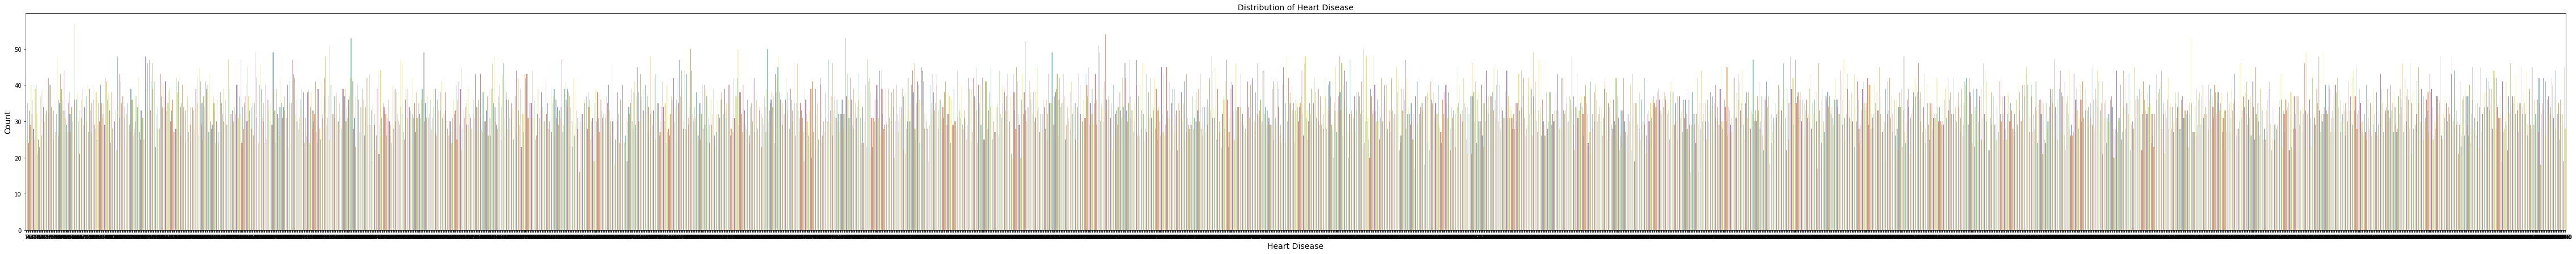

In [ ]:
plt.figure(figsize=(80, 7))

axs = sns.countplot(df['productID'], palette='Set3')

plt.title('Distribution of Products', fontsize=14)
plt.xlabel('Product IDs', fontsize=14)
plt.ylabel('Count', fontsize=14)

# **Preprocess the Data**



```
Not sure what the data will look like. Will the User ID's just be numbers, and will the porduct ID's also be numbers?
Either way, the data should be encoded 

If more encoding needs to be done refer to the link. 
```
[Guide to Encoding Categorical Values](https://pbpython.com/categorical-encoding.html)


In [ ]:
# Grab just the user ID's from the data frame
user_IDs = df["userID"].unique().tolist()
# Encode the user ID's
user2user_encoded = {x: i for i, x in enumerate(user_IDs)}
userencoded2user = {i: x for i, x in enumerate(user_IDs)}

# Grab the product ID's from the data frame
product_IDs = df["productID"].unique().tolist()
# Encode product labels
product2product_encoded = {x: i for i, x in enumerate(product_IDs)}
product_encoded2product = {i: x for i, x in enumerate(product_IDs)}

# Rename the dataframe with the encode values of user and product IDs 
df["user"] = df["userID"].map(user2user_encoded)  
df["product"] = df["productID"].map(product2product_encoded)

# Visual the data 
num_users = len(user2user_encoded)
num_product = len(product_encoded2product)

df["timestamp"] = df["timestamp"].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_timestamp = min(df["timestamp"])
max_timestamp = max(df["timestamp"])

print(
    "Number of users: {}, Number of Movies: {}, Min time on page: {}, Max time on page: {}".format(
        num_users, num_product, min_timestamp, max_timestamp
    )
)

Number of users: 610, Number of Movies: 3000, Min time on page: 1.0, Max time on page: 10000.0


# **Create Training and Validation Data**

In [ ]:
df = df.sample(frac=1, random_state=42)

# Comparing user and product values with the timestamp
x = df[["user", "product"]].values # Get values

# Apply normalization to all rows
y = df["timestamp"].apply(lambda x: (x - min_timestamp) / (max_timestamp - min_timestamp)).values # Normalize the targets between 0 and 1. 

# Break into .80 training and .20 validation
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

# **Create Model**



```
The model is embedded matricies of users and product (50 dimensional vectors)

Match score should be calculated using dot product. Per-user and per-product bias is added. 
Match score is sigmoid and are normalized. 
```



In [ ]:
EMBEDDING_SIZE = 50


class letsColab(keras.Model):
    def __init__(self, num_users, num_product, embedding_size, **kwargs):

        super(letsColab, self).__init__(**kwargs)

        # (self) --> access variables in the class
        self.num_users = num_users 
        self.num_product = num_product
        self.embedding_size = embedding_size

        # NN layer (user)
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal", # takes samples from a truncated normal distribution
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

        # NN layer (user bias) 
        self.user_bias = layers.Embedding(num_users, 1)
        
        self.product_embedding = layers.Embedding(
            num_product,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        
        # NN layer (product bias)
        self.product_bias = layers.Embedding(num_product, 1)


    # Call self and put them as inputs 
    def call(self, inputs):

        user_vector = self.user_embedding(inputs[:, 0])

        user_bias = self.user_bias(inputs[:, 0])

        movie_vector = self.product_embedding(inputs[:, 1])

        product_bias = self.product_bias(inputs[:, 1])

        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

        # Add all the components (including bias)
        x = dot_user_movie + user_bias + product_bias

        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


In [ ]:
model = letsColab(num_users, num_product, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1261/1261 [==============================] - 10s 6ms/step - loss: 0.6954 - val_loss: 0.6966
Epoch 2/5
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6977 - val_loss: 0.6996
Epoch 3/5
1261/1261 [==============================] - 5s 4ms/step - loss: 0.7004 - val_loss: 0.7013
Epoch 4/5
1261/1261 [==============================] - 5s 4ms/step - loss: 0.7026 - val_loss: 0.7036
Epoch 5/5
1261/1261 [==============================] - 4s 4ms/step - loss: 0.7032 - val_loss: 0.7047


# **Model Evaluation**

In [ ]:
model.summary()

Model: "lets_colab"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  30500     
                                                                 
 embedding_1 (Embedding)     multiple                  610       
                                                                 
 embedding_2 (Embedding)     multiple                  150000    
                                                                 
 embedding_3 (Embedding)     multiple                  3000      
                                                                 
Total params: 184,110
Trainable params: 184,110
Non-trainable params: 0
_________________________________________________________________


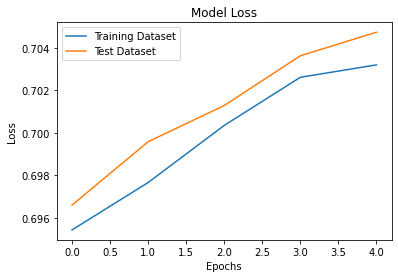

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["Training Dataset", "Test Dataset"], loc="upper left")
plt.show()


# **Testing Output**

In [ ]:
product_df = pd.read_csv("productNames.csv" , delimiter = ',')

# Let us get a user and see the top recommendations.

# Gets randome sample, just 1 value
user_id = df.userID.sample(1).iloc[0]

movies_watched_by_user = df[df.userID == user_id] # this line has me sus, might need to be changed to match correct dataframes. 
movies_not_watched = product_df[
    ~product_df["productID"].isin(movies_watched_by_user.productID.values) # choosing product ID's that are in the movies_watched_by_user and productID's 
]["productID"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(product_encoded2product.keys()))
)
movies_not_watched = [[product_encoded2product.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    product_encoded2product.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

# **Content Based System**

Create recommendations based off on the users preferences. Try and match users to perferences that they've clicked on or done before. 

NOTE: This system will not leverage ratings between other users. 

MAYBE: To generate recommended content when the user has not clicked on anything it might be best to recommned content based on score performance. That could be a lot of work and out of the scope of the data that is taken. It might just be easier to recommend based off of popular content. 

In [ ]:
data = dataGenerator('podcastData.csv')

In [ ]:
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm 

In [ ]:
def normalize(data):
    '''
    This function will normalize the input data to be between 0 and 1
    
    params:
        data (List) : The list of values you want to normalize
    
    returns:
        The input data normalized between 0 and 1
    '''
    min_val = min(data)
    if min_val < 0:
        data = [x + abs(min_val) for x in data]
    max_val = max(data)
    return [x/max_val for x in data]

In [ ]:
class CBRecommend():
    def __init__(self, df):
        self.df = df
        
    def cosine_sim(self, v1,v2):
        '''
        This function will calculate the cosine similarity between two vectors
        '''
        return sum(dot(v1,v2)/(norm(v1)*norm(v2)))
    
    def recommend(self, book_id, n_rec):
        """
        df (dataframe): The dataframe
        song_id (string): Representing the song name
        n_rec (int): amount of rec user wants
        """
        
        # calculate similarity of input book_id vector w.r.t all other vectors
        inputVec = self.df.loc[book_id].values
        self.df['sim']= self.df.apply(lambda x: self.cosine_sim(inputVec, x.values), axis=1)

        # returns top n user specified books
        return self.df.nlargest(columns='sim',n=n_rec)

if __name__ == '__main__':
    # import data
    df = pd.read_csv('fakeData.csv')

    # normalize the num_pages, ratings, price columns
    df['podcast_ID_TIME_norm'] = normalize(df['podcast_ID_TIME'].values)
    df['bundle_ID_TIME_norm'] = normalize(df['bundle_ID_TIME'].values)
    df['news_ID_TIME_norm'] = normalize(df['news_ID_TIME'].values)
    df['webinar_ID_TIME_norm'] = normalize(df['webinar_ID_TIME'].values)

    # ran on a sample as an example
    t = df.copy()
    cbr = CBRecommend(df = t)
    print(cbr.recommend(book_id = t.index[0], n_rec = 5))

TypeError: ignored